In [1]:
# Validation of the steady-state simulation - Case 1: MLP with Optimal settings
## Optimal Settings are like below:
# 1. Train/Validation/Test dataset ratio = 0.7/0.2/0.1
# 2. Cd scaling -> replaced as normalization for both Cl and Cd
# 3. Seperate the ML models into the two models, a model only for Cl and the other for Cd
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
### Defining parameters and hyperparameters of the model

n_units=128 # Number of units in the hidden layer of the MLP network
input_size = 100 + 3 # Size of input for the network (100 coefficients and 3 other parameters, AoA, h, beta)
lr = 1e-04 # Learning rate of the network
test_rate = 0.1 # Defines the ratio of test dataset
val_rate = 0.2 # Defines the ratio of validation dataset
n_data = 16 # Number of txt files from which the aerodynamic coefficients are extracted
batch_size = 20 # Mini-batch size

In [3]:
# Changing working directory

main_directory = 'D:\\VAWT_data\\flap_steady\\flap_steady'
os.chdir(main_directory)

In [4]:
## Basic parameters

c = 1 # Chord length
h = np.array([0.01, 0.02, 0.03]) * c # Height of the Gurney flaps
t = 0.02 * h # Thickness of the Gurney flaps
alpha = np.linspace(0, 16, 9).reshape((9,1)) # Angles of attack
beta = np.linspace(30, 90, 5).reshape((5,1))

In [5]:
h = h.reshape((-1,1))
t = t.reshape((-1,1))

In [6]:
n_alpha = alpha.shape[0] # Number of the angles of attack
n_beta = beta.shape[0] # Number of the Gurney flap inclination
n_h = h.shape[0] # Number of the height of the Gurney flaps
n_cases = n_data * n_alpha # Total number of cases(Number of geometries * Number of angles of attack)

In [7]:
## Creating Input dataset
# Defining the angles of attack

aa_ = np.zeros((n_cases,1))
for i in range(0, n_data):
    aa_[n_alpha*i:n_alpha*(i+1),:] = alpha[:,:]

In [8]:
aa = aa_ / np.max(alpha)

In [9]:
aa.shape

(144, 1)

In [10]:
# Defining beta, the Gurney flap inclination
# In case of mere NACA0018, the bb in those indexes are considered as zero.
beta_0 = np.zeros((n_alpha,1)) # Values for sheer NACA0018
b_ = np.ones((n_alpha,1)) # Template for the inclination for a single h and single beta
bb_imp = np.zeros((n_alpha*n_beta,1))

for j in range(n_beta):
    b_imp = b_ * beta[j]
    bb_imp[n_alpha*j:n_alpha*(j+1),:] = b_imp[:,:]
    
bb_imp = bb_imp.reshape((-1,1))

bb = np.vstack((beta_0, bb_imp, bb_imp, bb_imp))
bb = bb / np.max(beta)
    
print(bb.shape)

(144, 1)


In [11]:
# Defining the Gurney flap height
# In case of mere NACA0018, the hh in those indexes are considered as zero.

hh = np.concatenate((np.zeros(n_alpha), h[0]*np.ones(n_beta*n_alpha), h[1]*np.ones(n_beta*n_alpha), h[2]*np.ones(n_beta*n_alpha)))
hh = hh.reshape((-1,1))

In [12]:
hh = hh / np.max(h)

In [13]:
# Importing the coordinates of NACA0018 (airfoil15)
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out\\airfoil15"

csv_file_name = origin_coord + '\\airfoilOut15.txt'
data = pd.read_csv(csv_file_name, header=None)

In [14]:
baseline_coord = data.iloc[:,:].values

In [15]:
standard_coord = baseline_coord.reshape((1, -1))

In [16]:
airfoil_coord = np.repeat(standard_coord, n_cases, axis=0)
print(airfoil_coord.shape)

(144, 100)


In [17]:
# The rows mean the number of points at the Gurney flap
# and the columns mean the number of the cases
flap_left = np.zeros((15,5))
flap_right = np.zeros((15,5))

for i in range(n_h):
    # Defining coordinates of the flaps with respect to beta=90 degree.
    yLeft = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    yRight = np.linspace(-h[i]/5, -h[i], 5).reshape((-1,1))
    xLeft = 0.5*np.ones((5,1)) - 0.02*h[i]
    xRight = 0.5*np.ones((5,1))
    
    for j in range(n_beta):
        betaValue = beta[j]
        
        # Rotating transformation
        rotateTransf = np.array([[np.cos(90-betaValue), -np.sin(90-betaValue)],
                                 [np.sin(90-betaValue), np.cos(90-betaValue)]])
        rotateTransf = rotateTransf.reshape((2,2))
        
        LeftImp = np.hstack((xLeft-0.5, yLeft))
        RightImp = np.hstack((xRight-0.5, yRight))
        
        rotatedFlapLeft = rotateTransf @ LeftImp.T # shape: 2*5 (x-coordinates on first row, y-coordinates on second row)
        rotatedFlapRight = rotateTransf @ RightImp.T
        
        # All we need is the y-coordinates of the flaps
        flap_left[5*i+j,:] = rotatedFlapLeft[1,:]
        flap_right[5*i+j,:] = rotatedFlapRight[1,:]

In [18]:
# Combining y-coordinates from the left and the right side of the flaps
flap_coords = np.hstack((flap_left, np.flip(flap_right, axis=1)))
print(flap_coords.shape)

(15, 10)


In [19]:
# Placing the flap_coords into total coordinate variable
# Total coordinate = Airfoil coordinates + flap coordinates
flap_coords2 = np.zeros((n_cases, 10))
for i in range(n_alpha, n_cases):
    flap_coords2[i,:] = flap_coords[i%15,:]
    
print(flap_coords2.shape)

(144, 10)


In [20]:
total_coords = np.hstack((airfoil_coord, flap_coords2))
print(total_coords.shape)

(144, 110)


In [104]:
x = np.hstack((aa, hh, bb, total_coords))

In [109]:
## Creating output dataset - Cl and Cd
files_orig = os.listdir(main_directory)
files_target = [file for file in files_orig if file.endswith('.txt')]

In [111]:
os.chdir(main_directory)
target_df = pd.DataFrame()
for file in files_target:
    data = pd.read_table(file, header=None)
    target_df = pd.concat([target_df, data], axis=0)

In [112]:
cd_orig = target_df.iloc[:,3].values # Cd values

In [113]:
np.min(cd_orig)

0.01362853

In [114]:
np.max(cd_orig)

0.104101

In [115]:
cd = (cd_orig-np.min(cd_orig))/(np.max(cd_orig)-np.min(cd_orig))

In [116]:
y = cd.reshape((-1,1))

In [117]:
y.shape

(144, 1)

In [118]:
x_all, x_test, y_all, y_test = train_test_split(x, y, test_size=test_rate, random_state=1)

In [119]:
x_train, x_val, y_train, y_val = train_test_split(x_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [120]:
x_train.shape

(100, 113)

In [121]:
y_train.shape

(100, 1)

In [34]:
tf.keras.backend.set_image_data_format('channels_last')

In [35]:
input_data = tf.keras.Input(shape=(3+total_coords.shape[1]))

x_fc1 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc1')(input_data)
x_fc2 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc2')(x_fc1)
x_fc3 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc3')(x_fc2)
x_fc4 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc4')(x_fc3)
x_fc5 = tf.keras.layers.Dense(units=n_units, activation='relu', name='fc5')(x_fc4)

output_data = tf.keras.layers.Dense(units=1, activation='linear', name='outputLayer')(x_fc5)
# MLP(FC layer)-based
model = tf.keras.Model(input_data, output_data)

In [36]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 113)]             0         
                                                                 
 fc1 (Dense)                 (None, 128)               14592     
                                                                 
 fc2 (Dense)                 (None, 128)               16512     
                                                                 
 fc3 (Dense)                 (None, 128)               16512     
                                                                 
 fc4 (Dense)                 (None, 128)               16512     
                                                                 
 fc5 (Dense)                 (None, 128)               16512     
                                                                 
 outputLayer (Dense)         (None, 1)                 129   

In [37]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [38]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)

In [39]:
ckpt_name = model_directory + "20221130steadyValidation_MLP_val_"+str(val_rate) + "_test"+str(test_rate)+ "_" + str(n_units) +"units_OptimalSettings_checkpoint.h5"

ckpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, monitor="val_loss", mode='min', verbose=1, save_best_only=True)

es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=1000, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=200, factor=0.5,
                                          min_delta = 1e-09, min_lr=1e-06, verbose=1)

In [40]:
STEP_SIZE_TRAIN = len(x_train)//batch_size
VALIDATION_STEPS = len(x_val)//batch_size

In [41]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train, batch_size=batch_size,
                    validation_data=(x_val, y_val),
                    steps_per_epoch = STEP_SIZE_TRAIN, validation_steps=VALIDATION_STEPS,
                    epochs=10000, shuffle=True, callbacks=[es, ckpt, rp])
end = datetime.datetime.now()

Epoch 1/10000
1/5 [=====>........................] - ETA: 3s - loss: 0.1555 - rmse: 0.3943
Epoch 1: val_loss improved from inf to 0.10674, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 1s 82ms/step - loss: 0.1595 - rmse: 0.3994 - val_loss: 0.1067 - val_rmse: 0.3267 - lr: 1.0000e-04
Epoch 2/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.1921 - rmse: 0.4383
Epoch 2: val_loss improved from 0.10674 to 0.08638, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 19ms/step - loss: 0.1351 - rmse: 0.3675 - val_loss: 0.0864 - val_rmse: 0.2939 - lr: 1.0000e-04
Epoch 3/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.1007 - rmse: 0.3173
Epoch 3: val_loss improved from 0.08638 to 0.06970, saving model to D:\TrainedModels\2022113020221130st

1/5 [=====>........................] - ETA: 0s - loss: 0.0083 - rmse: 0.0912
Epoch 21: val_loss improved from 0.00921 to 0.00837, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 20ms/step - loss: 0.0120 - rmse: 0.1095 - val_loss: 0.0084 - val_rmse: 0.0915 - lr: 1.0000e-04
Epoch 22/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0111 - rmse: 0.1055
Epoch 22: val_loss did not improve from 0.00837
5/5 [==============================] - 0s 9ms/step - loss: 0.0109 - rmse: 0.1046 - val_loss: 0.0087 - val_rmse: 0.0932 - lr: 1.0000e-04
Epoch 23/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0071 - rmse: 0.0840
Epoch 23: val_loss improved from 0.00837 to 0.00802, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 21ms/step - loss: 0.

Epoch 45/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0049 - rmse: 0.0702
Epoch 45: val_loss improved from 0.00467 to 0.00431, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 19ms/step - loss: 0.0038 - rmse: 0.0616 - val_loss: 0.0043 - val_rmse: 0.0656 - lr: 1.0000e-04
Epoch 46/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0016 - rmse: 0.0400
Epoch 46: val_loss did not improve from 0.00431
5/5 [==============================] - 0s 10ms/step - loss: 0.0036 - rmse: 0.0604 - val_loss: 0.0045 - val_rmse: 0.0669 - lr: 1.0000e-04
Epoch 47/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0045 - rmse: 0.0673
Epoch 47: val_loss improved from 0.00431 to 0.00421, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 41ms

Epoch 69/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0034 - rmse: 0.0583
Epoch 69: val_loss improved from 0.00316 to 0.00305, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 0.0026 - rmse: 0.0505 - val_loss: 0.0031 - val_rmse: 0.0552 - lr: 1.0000e-04
Epoch 70/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0010 - rmse: 0.0319
Epoch 70: val_loss did not improve from 0.00305
5/5 [==============================] - 0s 11ms/step - loss: 0.0025 - rmse: 0.0505 - val_loss: 0.0031 - val_rmse: 0.0555 - lr: 1.0000e-04
Epoch 71/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0344
Epoch 71: val_loss improved from 0.00305 to 0.00303, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms

5/5 [==============================] - 0s 12ms/step - loss: 0.0020 - rmse: 0.0450 - val_loss: 0.0025 - val_rmse: 0.0499 - lr: 1.0000e-04
Epoch 94/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0014 - rmse: 0.0369
Epoch 94: val_loss improved from 0.00245 to 0.00243, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 0.0019 - rmse: 0.0436 - val_loss: 0.0024 - val_rmse: 0.0493 - lr: 1.0000e-04
Epoch 95/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0335
Epoch 95: val_loss improved from 0.00243 to 0.00242, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 22ms/step - loss: 0.0022 - rmse: 0.0469 - val_loss: 0.0024 - val_rmse: 0.0492 - lr: 1.0000e-04
Epoch 96/10000
1/5 [=====>.......................

Epoch 119/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0337
Epoch 119: val_loss improved from 0.00208 to 0.00204, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 24ms/step - loss: 0.0015 - rmse: 0.0392 - val_loss: 0.0020 - val_rmse: 0.0452 - lr: 1.0000e-04
Epoch 120/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0022 - rmse: 0.0469
Epoch 120: val_loss did not improve from 0.00204
5/5 [==============================] - 0s 12ms/step - loss: 0.0014 - rmse: 0.0380 - val_loss: 0.0021 - val_rmse: 0.0458 - lr: 1.0000e-04
Epoch 121/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.7840e-04 - rmse: 0.0240
Epoch 121: val_loss improved from 0.00204 to 0.00202, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================]

Epoch 144/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0018 - rmse: 0.0430
Epoch 144: val_loss did not improve from 0.00168
5/5 [==============================] - 0s 12ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0017 - val_rmse: 0.0416 - lr: 1.0000e-04
Epoch 145/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.2260e-04 - rmse: 0.0304
Epoch 145: val_loss did not improve from 0.00168
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0330 - val_loss: 0.0017 - val_rmse: 0.0412 - lr: 1.0000e-04
Epoch 146/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0012 - rmse: 0.0350
Epoch 146: val_loss did not improve from 0.00168
5/5 [==============================] - 0s 11ms/step - loss: 0.0011 - rmse: 0.0328 - val_loss: 0.0017 - val_rmse: 0.0411 - lr: 1.0000e-04
Epoch 147/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9664e-04 - rmse: 0.0140
Epoch 147: val_loss improved from 0.00168 to 0.00160, saving m

Epoch 169/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5740e-04 - rmse: 0.0256
Epoch 169: val_loss did not improve from 0.00130
5/5 [==============================] - 0s 12ms/step - loss: 8.3207e-04 - rmse: 0.0288 - val_loss: 0.0013 - val_rmse: 0.0364 - lr: 1.0000e-04
Epoch 170/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2636e-04 - rmse: 0.0250
Epoch 170: val_loss did not improve from 0.00130
5/5 [==============================] - 0s 12ms/step - loss: 7.7130e-04 - rmse: 0.0278 - val_loss: 0.0013 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 171/10000
1/5 [=====>........................] - ETA: 0s - loss: 0.0011 - rmse: 0.0335
Epoch 171: val_loss did not improve from 0.00130
5/5 [==============================] - 0s 11ms/step - loss: 7.4844e-04 - rmse: 0.0274 - val_loss: 0.0013 - val_rmse: 0.0365 - lr: 1.0000e-04
Epoch 172/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.7808e-04 - rmse: 0.0296
Epoch 172: val_loss improved from 0.00130 to 0

5/5 [==============================] - 0s 12ms/step - loss: 5.4300e-04 - rmse: 0.0233 - val_loss: 0.0011 - val_rmse: 0.0330 - lr: 1.0000e-04
Epoch 195/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2979e-04 - rmse: 0.0251
Epoch 195: val_loss did not improve from 0.00101
5/5 [==============================] - 0s 12ms/step - loss: 5.2367e-04 - rmse: 0.0229 - val_loss: 0.0010 - val_rmse: 0.0321 - lr: 1.0000e-04
Epoch 196/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2897e-04 - rmse: 0.0114
Epoch 196: val_loss did not improve from 0.00101
5/5 [==============================] - 0s 11ms/step - loss: 5.1612e-04 - rmse: 0.0227 - val_loss: 0.0011 - val_rmse: 0.0325 - lr: 1.0000e-04
Epoch 197/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0966e-04 - rmse: 0.0105
Epoch 197: val_loss improved from 0.00101 to 0.00098, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [====

Epoch 220/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2903e-04 - rmse: 0.0207
Epoch 220: val_loss improved from 0.00082 to 0.00080, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 26ms/step - loss: 3.4473e-04 - rmse: 0.0186 - val_loss: 8.0438e-04 - val_rmse: 0.0284 - lr: 1.0000e-04
Epoch 221/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2930e-04 - rmse: 0.0230
Epoch 221: val_loss improved from 0.00080 to 0.00077, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 25ms/step - loss: 3.3463e-04 - rmse: 0.0183 - val_loss: 7.7460e-04 - val_rmse: 0.0278 - lr: 1.0000e-04
Epoch 222/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9594e-04 - rmse: 0.0299
Epoch 222: val_loss did not improve from 0.00077
5/5 [=======

1/5 [=====>........................] - ETA: 0s - loss: 3.8254e-04 - rmse: 0.0196
Epoch 244: val_loss did not improve from 0.00066
5/5 [==============================] - 0s 12ms/step - loss: 1.9904e-04 - rmse: 0.0141 - val_loss: 7.0320e-04 - val_rmse: 0.0265 - lr: 1.0000e-04
Epoch 245/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.3598e-04 - rmse: 0.0117
Epoch 245: val_loss improved from 0.00066 to 0.00063, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 30ms/step - loss: 2.2873e-04 - rmse: 0.0151 - val_loss: 6.3188e-04 - val_rmse: 0.0251 - lr: 1.0000e-04
Epoch 246/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3644e-05 - rmse: 0.0058
Epoch 246: val_loss did not improve from 0.00063
5/5 [==============================] - 0s 12ms/step - loss: 2.1120e-04 - rmse: 0.0145 - val_loss: 6.4369e-04 - val_rmse: 0.0254 - lr: 1.0000e-04
Epoch 247/100

Epoch 270/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1282e-04 - rmse: 0.0146
Epoch 270: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 12ms/step - loss: 1.3603e-04 - rmse: 0.0117 - val_loss: 5.3994e-04 - val_rmse: 0.0232 - lr: 1.0000e-04
Epoch 271/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6387e-05 - rmse: 0.0068
Epoch 271: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 11ms/step - loss: 1.4267e-04 - rmse: 0.0119 - val_loss: 5.1585e-04 - val_rmse: 0.0227 - lr: 1.0000e-04
Epoch 272/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4048e-04 - rmse: 0.0155
Epoch 272: val_loss did not improve from 0.00049
5/5 [==============================] - 0s 11ms/step - loss: 1.7422e-04 - rmse: 0.0132 - val_loss: 6.9577e-04 - val_rmse: 0.0264 - lr: 1.0000e-04
Epoch 273/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2611e-04 - rmse: 0.0150
Epoch 273: val_loss improved f

Epoch 295/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7242e-05 - rmse: 0.0099
Epoch 295: val_loss did not improve from 0.00039
5/5 [==============================] - 0s 12ms/step - loss: 5.7074e-05 - rmse: 0.0076 - val_loss: 4.2519e-04 - val_rmse: 0.0206 - lr: 1.0000e-04
Epoch 296/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6775e-05 - rmse: 0.0082
Epoch 296: val_loss did not improve from 0.00039
5/5 [==============================] - 0s 12ms/step - loss: 5.4119e-05 - rmse: 0.0074 - val_loss: 4.0293e-04 - val_rmse: 0.0201 - lr: 1.0000e-04
Epoch 297/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.1379e-06 - rmse: 0.0025
Epoch 297: val_loss did not improve from 0.00039
5/5 [==============================] - 0s 12ms/step - loss: 6.0701e-05 - rmse: 0.0078 - val_loss: 4.6861e-04 - val_rmse: 0.0216 - lr: 1.0000e-04
Epoch 298/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3501e-05 - rmse: 0.0086
Epoch 298: val_loss improved f

1/5 [=====>........................] - ETA: 0s - loss: 2.2792e-05 - rmse: 0.0048
Epoch 320: val_loss improved from 0.00033 to 0.00032, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 3.3501e-05 - rmse: 0.0058 - val_loss: 3.2227e-04 - val_rmse: 0.0180 - lr: 1.0000e-04
Epoch 321/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.9626e-05 - rmse: 0.0083
Epoch 321: val_loss did not improve from 0.00032
5/5 [==============================] - 0s 12ms/step - loss: 3.9494e-05 - rmse: 0.0063 - val_loss: 3.4416e-04 - val_rmse: 0.0186 - lr: 1.0000e-04
Epoch 322/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2373e-05 - rmse: 0.0047
Epoch 322: val_loss did not improve from 0.00032
5/5 [==============================] - 0s 12ms/step - loss: 4.2188e-05 - rmse: 0.0065 - val_loss: 3.5686e-04 - val_rmse: 0.0189 - lr: 1.0000e-04
Epoch 323/100

Epoch 346/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1876e-05 - rmse: 0.0034
Epoch 346: val_loss did not improve from 0.00028
5/5 [==============================] - 0s 12ms/step - loss: 2.0845e-05 - rmse: 0.0046 - val_loss: 3.1529e-04 - val_rmse: 0.0178 - lr: 1.0000e-04
Epoch 347/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9354e-05 - rmse: 0.0044
Epoch 347: val_loss improved from 0.00028 to 0.00028, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 27ms/step - loss: 2.4127e-05 - rmse: 0.0049 - val_loss: 2.7861e-04 - val_rmse: 0.0167 - lr: 1.0000e-04
Epoch 348/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.9547e-05 - rmse: 0.0077
Epoch 348: val_loss did not improve from 0.00028
5/5 [==============================] - 0s 12ms/step - loss: 3.2108e-05 - rmse: 0.0057 - val_loss: 2.9446e-04 - val_rmse: 0.0172 - lr: 1.0000e-

5/5 [==============================] - 0s 12ms/step - loss: 1.0873e-05 - rmse: 0.0033 - val_loss: 2.5549e-04 - val_rmse: 0.0160 - lr: 1.0000e-04
Epoch 372/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0369e-06 - rmse: 0.0027
Epoch 372: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 12ms/step - loss: 1.0249e-05 - rmse: 0.0032 - val_loss: 2.4308e-04 - val_rmse: 0.0156 - lr: 1.0000e-04
Epoch 373/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1371e-05 - rmse: 0.0034
Epoch 373: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 11ms/step - loss: 8.9192e-06 - rmse: 0.0030 - val_loss: 2.6285e-04 - val_rmse: 0.0162 - lr: 1.0000e-04
Epoch 374/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5405e-06 - rmse: 0.0026
Epoch 374: val_loss did not improve from 0.00024
5/5 [==============================] - 0s 12ms/step - loss: 1.0050e-05 - rmse: 0.0032 - val_loss: 2.5089e-04 - val_rmse: 0.0158

5/5 [==============================] - 0s 12ms/step - loss: 5.9694e-06 - rmse: 0.0024 - val_loss: 2.2217e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 398/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.9489e-06 - rmse: 0.0030
Epoch 398: val_loss did not improve from 0.00022
5/5 [==============================] - 0s 12ms/step - loss: 7.0627e-06 - rmse: 0.0027 - val_loss: 2.2249e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 399/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.2086e-06 - rmse: 0.0023
Epoch 399: val_loss improved from 0.00022 to 0.00021, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 31ms/step - loss: 5.7916e-06 - rmse: 0.0024 - val_loss: 2.1336e-04 - val_rmse: 0.0146 - lr: 1.0000e-04
Epoch 400/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3447e-06 - rmse: 0.0027
Epoch 400: val_loss did not improve from 0.000

1/5 [=====>........................] - ETA: 0s - loss: 3.4008e-06 - rmse: 0.0018
Epoch 424: val_loss did not improve from 0.00020
5/5 [==============================] - 0s 12ms/step - loss: 4.3920e-06 - rmse: 0.0021 - val_loss: 2.0211e-04 - val_rmse: 0.0142 - lr: 1.0000e-04
Epoch 425/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.2469e-06 - rmse: 0.0025
Epoch 425: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [==============================] - 0s 22ms/step - loss: 3.9999e-06 - rmse: 0.0020 - val_loss: 1.9966e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 426/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8540e-06 - rmse: 0.0014
Epoch 426: val_loss improved from 0.00020 to 0.00020, saving model to D:\TrainedModels\2022113020221130steadyValidation_MLP_val_0.2_test0.1_128units_OptimalSettings_checkpoint.h5
5/5 [=======================

Epoch 450/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.8253e-06 - rmse: 0.0022
Epoch 450: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 11ms/step - loss: 7.2400e-06 - rmse: 0.0027 - val_loss: 1.8074e-04 - val_rmse: 0.0134 - lr: 1.0000e-04
Epoch 451/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4738e-06 - rmse: 0.0031
Epoch 451: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 12ms/step - loss: 1.0460e-05 - rmse: 0.0032 - val_loss: 2.2249e-04 - val_rmse: 0.0149 - lr: 1.0000e-04
Epoch 452/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1017e-05 - rmse: 0.0033
Epoch 452: val_loss did not improve from 0.00018
5/5 [==============================] - 0s 11ms/step - loss: 9.2140e-06 - rmse: 0.0030 - val_loss: 2.1810e-04 - val_rmse: 0.0148 - lr: 1.0000e-04
Epoch 453/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.8865e-06 - rmse: 0.0030
Epoch 453: val_loss did not im

Epoch 478/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.1340e-06 - rmse: 0.0020
Epoch 478: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 12ms/step - loss: 2.7487e-06 - rmse: 0.0017 - val_loss: 1.8316e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 479/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1144e-06 - rmse: 0.0018
Epoch 479: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 11ms/step - loss: 2.9369e-06 - rmse: 0.0017 - val_loss: 1.9821e-04 - val_rmse: 0.0141 - lr: 1.0000e-04
Epoch 480/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4560e-07 - rmse: 9.7242e-04
Epoch 480: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 12ms/step - loss: 2.6441e-06 - rmse: 0.0016 - val_loss: 1.8159e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 481/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7824e-06 - rmse: 0.0017
Epoch 481: val_loss did no

1/5 [=====>........................] - ETA: 0s - loss: 3.2994e-06 - rmse: 0.0018
Epoch 506: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 11ms/step - loss: 2.6894e-06 - rmse: 0.0016 - val_loss: 1.8341e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 507/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1967e-06 - rmse: 0.0011
Epoch 507: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 12ms/step - loss: 2.2704e-06 - rmse: 0.0015 - val_loss: 1.8676e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 508/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4006e-06 - rmse: 0.0018
Epoch 508: val_loss did not improve from 0.00017
5/5 [==============================] - 0s 11ms/step - loss: 1.9875e-06 - rmse: 0.0014 - val_loss: 1.8231e-04 - val_rmse: 0.0135 - lr: 1.0000e-04
Epoch 509/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4586e-06 - rmse: 0.0012
Epoch 509: val_loss did not improve from 0.000

Epoch 534/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3707e-06 - rmse: 0.0027
Epoch 534: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 12ms/step - loss: 1.5411e-05 - rmse: 0.0039 - val_loss: 2.0547e-04 - val_rmse: 0.0143 - lr: 1.0000e-04
Epoch 535/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9800e-05 - rmse: 0.0055
Epoch 535: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 12ms/step - loss: 1.4990e-05 - rmse: 0.0039 - val_loss: 1.9386e-04 - val_rmse: 0.0139 - lr: 1.0000e-04
Epoch 536/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4023e-05 - rmse: 0.0037
Epoch 536: val_loss did not improve from 0.00016
5/5 [==============================] - 0s 12ms/step - loss: 1.4078e-05 - rmse: 0.0038 - val_loss: 1.8725e-04 - val_rmse: 0.0137 - lr: 1.0000e-04
Epoch 537/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3545e-06 - rmse: 0.0021
Epoch 537: val_loss did not im

Epoch 562/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8076e-06 - rmse: 0.0017
Epoch 562: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.5721e-06 - rmse: 0.0013 - val_loss: 1.8382e-04 - val_rmse: 0.0136 - lr: 1.0000e-04
Epoch 563/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5215e-06 - rmse: 0.0016
Epoch 563: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.4276e-06 - rmse: 0.0012 - val_loss: 1.6585e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 564/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6646e-06 - rmse: 0.0013
Epoch 564: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 1.4856e-06 - rmse: 0.0012 - val_loss: 1.7195e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 565/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.6843e-07 - rmse: 8.7660e-04
Epoch 565: val_loss did no

Epoch 590/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.5647e-07 - rmse: 8.6975e-04
Epoch 590: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.6437e-07 - rmse: 7.5125e-04 - val_loss: 1.6860e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 591/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4449e-07 - rmse: 5.8693e-04
Epoch 591: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.3013e-07 - rmse: 7.2810e-04 - val_loss: 1.6955e-04 - val_rmse: 0.0130 - lr: 1.0000e-04
Epoch 592/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5565e-07 - rmse: 7.4542e-04
Epoch 592: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 5.3226e-07 - rmse: 7.2956e-04 - val_loss: 1.7142e-04 - val_rmse: 0.0131 - lr: 1.0000e-04
Epoch 593/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0068e-07 - rmse: 6.3299e-04
Ep

5/5 [==============================] - 0s 12ms/step - loss: 6.5753e-07 - rmse: 8.1088e-04 - val_loss: 1.6116e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 618/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.5542e-07 - rmse: 6.7485e-04
Epoch 618: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.0564e-07 - rmse: 7.7823e-04 - val_loss: 1.6765e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 619/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9846e-07 - rmse: 7.0602e-04
Epoch 619: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.8653e-07 - rmse: 8.2857e-04 - val_loss: 1.6403e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 620/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.2756e-07 - rmse: 6.5388e-04
Epoch 620: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.6451e-07 - rmse: 7.5134e-04 - val_loss: 1

Epoch 645/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8777e-07 - rmse: 4.3333e-04
Epoch 645: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7436e-07 - rmse: 4.1757e-04 - val_loss: 1.6578e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 646/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0048e-07 - rmse: 3.1699e-04
Epoch 646: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7469e-07 - rmse: 4.1796e-04 - val_loss: 1.6530e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 647/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.3283e-08 - rmse: 3.0542e-04
Epoch 647: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.6465e-07 - rmse: 4.0577e-04 - val_loss: 1.6456e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 648/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0708e-07 - rmse: 3.2723e-04
Ep

Epoch 673/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0068e-06 - rmse: 0.0010
Epoch 673: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 7.5257e-07 - rmse: 8.6751e-04 - val_loss: 1.6056e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 674/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3518e-07 - rmse: 9.1388e-04
Epoch 674: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 8.5260e-07 - rmse: 9.2336e-04 - val_loss: 1.5937e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 675/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.7649e-07 - rmse: 8.2249e-04
Epoch 675: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.5959e-06 - rmse: 0.0013 - val_loss: 1.5826e-04 - val_rmse: 0.0126 - lr: 1.0000e-04
Epoch 676/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6137e-06 - rmse: 0.0016
Epoch 676: val

Epoch 701/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0226e-07 - rmse: 4.4973e-04
Epoch 701: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.3998e-07 - rmse: 5.8308e-04 - val_loss: 1.6370e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 702/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4687e-07 - rmse: 4.9686e-04
Epoch 702: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.7144e-07 - rmse: 6.0946e-04 - val_loss: 1.6332e-04 - val_rmse: 0.0128 - lr: 1.0000e-04
Epoch 703/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3713e-07 - rmse: 6.6115e-04
Epoch 703: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 2.2104e-07 - rmse: 4.7014e-04 - val_loss: 1.6212e-04 - val_rmse: 0.0127 - lr: 1.0000e-04
Epoch 704/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4228e-07 - rmse: 3.7720e-04
Ep

5/5 [==============================] - 0s 11ms/step - loss: 1.2459e-06 - rmse: 0.0011 - val_loss: 1.6598e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 729/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5242e-06 - rmse: 0.0012
Epoch 729: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.5465e-06 - rmse: 0.0016 - val_loss: 1.7527e-04 - val_rmse: 0.0132 - lr: 1.0000e-04
Epoch 730/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1096e-06 - rmse: 0.0018
Epoch 730: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 2.6092e-06 - rmse: 0.0016 - val_loss: 1.6646e-04 - val_rmse: 0.0129 - lr: 1.0000e-04
Epoch 731/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9874e-06 - rmse: 0.0014
Epoch 731: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 1.7573e-06 - rmse: 0.0013 - val_loss: 1.6596e-04 - val_rmse: 0.0129

Epoch 756/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.4976e-08 - rmse: 3.0818e-04
Epoch 756: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 8.9358e-08 - rmse: 2.9893e-04 - val_loss: 1.6110e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 757/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.4144e-08 - rmse: 2.5327e-04
Epoch 757: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0282e-07 - rmse: 3.2066e-04 - val_loss: 1.6019e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 758/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.7110e-08 - rmse: 2.1705e-04
Epoch 758: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 9.9124e-08 - rmse: 3.1484e-04 - val_loss: 1.5903e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 759/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.7141e-08 - rmse: 3.1167e-04
Ep

5/5 [==============================] - 0s 12ms/step - loss: 5.2326e-08 - rmse: 2.2875e-04 - val_loss: 1.5987e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 784/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8790e-08 - rmse: 1.9695e-04
Epoch 784: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.0117e-08 - rmse: 2.2387e-04 - val_loss: 1.6029e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 785/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.5058e-08 - rmse: 2.3465e-04
Epoch 785: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.5268e-08 - rmse: 2.3509e-04 - val_loss: 1.6130e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 786/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.8459e-08 - rmse: 2.8011e-04
Epoch 786: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.4846e-08 - rmse: 2.5465e-04 - val_loss: 1

Epoch 811/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2782e-08 - rmse: 1.5094e-04
Epoch 811: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.0085e-08 - rmse: 2.0021e-04 - val_loss: 1.5979e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 812/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9227e-08 - rmse: 1.7096e-04
Epoch 812: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.4119e-08 - rmse: 2.1004e-04 - val_loss: 1.6071e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 813/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.4572e-08 - rmse: 1.8593e-04
Epoch 813: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.9568e-08 - rmse: 2.2264e-04 - val_loss: 1.6063e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 814/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.1534e-08 - rmse: 2.8554e-04
Ep

5/5 [==============================] - 0s 12ms/step - loss: 8.1554e-08 - rmse: 2.8558e-04 - val_loss: 1.6273e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 839/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0297e-07 - rmse: 3.2089e-04
Epoch 839: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.5122e-08 - rmse: 2.5519e-04 - val_loss: 1.6077e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 840/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.6581e-08 - rmse: 2.9425e-04
Epoch 840: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.3941e-08 - rmse: 2.5286e-04 - val_loss: 1.6148e-04 - val_rmse: 0.0127 - lr: 5.0000e-05
Epoch 841/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8512e-08 - rmse: 1.6886e-04
Epoch 841: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.6387e-08 - rmse: 2.1538e-04 - val_loss: 1

Epoch 866/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0940e-06 - rmse: 0.0010
Epoch 866: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 6.1266e-07 - rmse: 7.8272e-04 - val_loss: 1.5364e-04 - val_rmse: 0.0124 - lr: 5.0000e-05
Epoch 867/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1085e-06 - rmse: 0.0011
Epoch 867: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 9.5009e-07 - rmse: 9.7473e-04 - val_loss: 1.5873e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 868/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6857e-07 - rmse: 5.1823e-04
Epoch 868: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.0140e-07 - rmse: 6.3356e-04 - val_loss: 1.6369e-04 - val_rmse: 0.0128 - lr: 5.0000e-05
Epoch 869/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8404e-06 - rmse: 0.0014
Epoch 869: val

5/5 [==============================] - 0s 12ms/step - loss: 2.5358e-08 - rmse: 1.5924e-04 - val_loss: 1.5945e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 894/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9193e-08 - rmse: 1.3854e-04
Epoch 894: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.1098e-08 - rmse: 1.7635e-04 - val_loss: 1.5946e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 895/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6123e-08 - rmse: 1.9006e-04
Epoch 895: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.5768e-08 - rmse: 1.6053e-04 - val_loss: 1.5974e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 896/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.0336e-08 - rmse: 1.4261e-04
Epoch 896: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.4922e-08 - rmse: 1.5787e-04 - val_loss: 1

Epoch 921/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1282e-08 - rmse: 1.4588e-04
Epoch 921: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.7254e-08 - rmse: 1.9301e-04 - val_loss: 1.5813e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 922/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4280e-09 - rmse: 9.1804e-05
Epoch 922: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.2662e-08 - rmse: 1.8073e-04 - val_loss: 1.5729e-04 - val_rmse: 0.0125 - lr: 5.0000e-05
Epoch 923/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2071e-08 - rmse: 1.0987e-04
Epoch 923: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.7241e-08 - rmse: 1.9298e-04 - val_loss: 1.5893e-04 - val_rmse: 0.0126 - lr: 5.0000e-05
Epoch 924/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6602e-08 - rmse: 1.2885e-04
Ep

1/5 [=====>........................] - ETA: 0s - loss: 4.0750e-08 - rmse: 2.0187e-04
Epoch 948: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.0245e-08 - rmse: 1.7391e-04 - val_loss: 1.5672e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 949/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2120e-08 - rmse: 1.1009e-04
Epoch 949: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.1253e-08 - rmse: 1.4579e-04 - val_loss: 1.5771e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 950/10000
1/5 [=====>........................] - ETA: 0s - loss: 9.6454e-09 - rmse: 9.8211e-05
Epoch 950: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.9809e-08 - rmse: 1.4074e-04 - val_loss: 1.5857e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 951/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4522e-08 - rmse: 1.5659e-04
Epoch 951: val_los

5/5 [==============================] - 0s 12ms/step - loss: 1.1308e-08 - rmse: 1.0634e-04 - val_loss: 1.5780e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 976/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4542e-08 - rmse: 1.2059e-04
Epoch 976: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 1.2930e-08 - rmse: 1.1371e-04 - val_loss: 1.5798e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 977/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1531e-08 - rmse: 1.0738e-04
Epoch 977: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.3479e-08 - rmse: 1.1610e-04 - val_loss: 1.5812e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 978/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5235e-08 - rmse: 1.2343e-04
Epoch 978: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.5964e-08 - rmse: 1.2635e-04 - val_loss: 1

Epoch 1003/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.9351e-08 - rmse: 1.3911e-04
Epoch 1003: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0007e-08 - rmse: 1.0003e-04 - val_loss: 1.5781e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1004/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.8780e-09 - rmse: 7.6668e-05
Epoch 1004: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0998e-08 - rmse: 1.0487e-04 - val_loss: 1.5814e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1005/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2518e-08 - rmse: 1.5006e-04
Epoch 1005: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 9.3573e-09 - rmse: 9.6733e-05 - val_loss: 1.5805e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1006/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2300e-08 - rmse: 1.1091

1/5 [=====>........................] - ETA: 0s - loss: 4.2776e-09 - rmse: 6.5403e-05
Epoch 1030: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 9.1577e-09 - rmse: 9.5696e-05 - val_loss: 1.5711e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1031/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.7257e-08 - rmse: 1.3137e-04
Epoch 1031: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0310e-08 - rmse: 1.0154e-04 - val_loss: 1.5767e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1032/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4439e-09 - rmse: 6.6663e-05
Epoch 1032: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0331e-08 - rmse: 1.0164e-04 - val_loss: 1.5783e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1033/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3425e-08 - rmse: 1.5305e-04
Epoch 1033: 

1/5 [=====>........................] - ETA: 0s - loss: 1.1737e-08 - rmse: 1.0834e-04
Epoch 1057: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.5345e-08 - rmse: 1.2387e-04 - val_loss: 1.5737e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1058/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1682e-08 - rmse: 1.4725e-04
Epoch 1058: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.8252e-08 - rmse: 1.3510e-04 - val_loss: 1.5740e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1059/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0788e-08 - rmse: 1.0387e-04
Epoch 1059: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 13ms/step - loss: 1.5887e-08 - rmse: 1.2604e-04 - val_loss: 1.5813e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1060/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2831e-08 - rmse: 1.5110e-04
Epoch 1060: 

1/5 [=====>........................] - ETA: 0s - loss: 9.3743e-09 - rmse: 9.6821e-05
Epoch 1084: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 8.5397e-09 - rmse: 9.2410e-05 - val_loss: 1.5787e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1085/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.1457e-08 - rmse: 1.0704e-04
Epoch 1085: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 9.7403e-09 - rmse: 9.8693e-05 - val_loss: 1.5754e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1086/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0403e-08 - rmse: 1.0199e-04
Epoch 1086: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.0208e-08 - rmse: 1.0104e-04 - val_loss: 1.5679e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1087/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.2326e-09 - rmse: 8.5045e-05
Epoch 1087: 

1/5 [=====>........................] - ETA: 0s - loss: 1.0073e-08 - rmse: 1.0037e-04
Epoch 1111: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.9016e-08 - rmse: 1.3790e-04 - val_loss: 1.5781e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1112/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.6215e-08 - rmse: 1.2734e-04
Epoch 1112: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.5665e-08 - rmse: 1.6020e-04 - val_loss: 1.5728e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1113/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6447e-08 - rmse: 2.1552e-04
Epoch 1113: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.3876e-08 - rmse: 1.5452e-04 - val_loss: 1.5803e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1114/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6444e-08 - rmse: 1.6261e-04
Epoch 1114: 

1/5 [=====>........................] - ETA: 0s - loss: 2.1214e-08 - rmse: 1.4565e-04
Epoch 1138: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.6461e-08 - rmse: 1.2830e-04 - val_loss: 1.5780e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1139/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2559e-08 - rmse: 1.1207e-04
Epoch 1139: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.1146e-08 - rmse: 1.0557e-04 - val_loss: 1.5682e-04 - val_rmse: 0.0125 - lr: 2.5000e-05
Epoch 1140/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2441e-08 - rmse: 1.4980e-04
Epoch 1140: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.3242e-08 - rmse: 1.1507e-04 - val_loss: 1.5778e-04 - val_rmse: 0.0126 - lr: 2.5000e-05
Epoch 1141/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.3899e-09 - rmse: 9.1596e-05
Epoch 1141: 

1/5 [=====>........................] - ETA: 0s - loss: 2.9661e-09 - rmse: 5.4462e-05
Epoch 1165: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.3998e-09 - rmse: 6.6331e-05 - val_loss: 1.5695e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1166/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.6132e-09 - rmse: 8.1321e-05
Epoch 1166: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.1615e-09 - rmse: 6.4510e-05 - val_loss: 1.5677e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1167/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.7966e-09 - rmse: 5.2883e-05
Epoch 1167: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 13ms/step - loss: 4.3156e-09 - rmse: 6.5693e-05 - val_loss: 1.5692e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1168/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.3345e-09 - rmse: 8.5642e-05
Epoch 1168: 

1/5 [=====>........................] - ETA: 0s - loss: 2.0552e-09 - rmse: 4.5334e-05
Epoch 1192: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.9100e-09 - rmse: 6.2530e-05 - val_loss: 1.5681e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1193/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.2211e-09 - rmse: 4.7128e-05
Epoch 1193: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 13ms/step - loss: 3.8607e-09 - rmse: 6.2134e-05 - val_loss: 1.5686e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1194/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9774e-09 - rmse: 6.3066e-05
Epoch 1194: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 4.0246e-09 - rmse: 6.3440e-05 - val_loss: 1.5681e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1195/10000
1/5 [=====>........................] - ETA: 0s - loss: 7.0070e-09 - rmse: 8.3708e-05
Epoch 1195: 

1/5 [=====>........................] - ETA: 0s - loss: 2.0135e-09 - rmse: 4.4872e-05
Epoch 1219: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.9051e-09 - rmse: 7.0036e-05 - val_loss: 1.5694e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1220/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4136e-09 - rmse: 3.7598e-05
Epoch 1220: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 5.9789e-09 - rmse: 7.7323e-05 - val_loss: 1.5653e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1221/10000
1/5 [=====>........................] - ETA: 0s - loss: 5.6180e-09 - rmse: 7.4953e-05
Epoch 1221: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.2909e-09 - rmse: 6.5505e-05 - val_loss: 1.5674e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1222/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3978e-09 - rmse: 4.8968e-05
Epoch 1222: 

1/5 [=====>........................] - ETA: 0s - loss: 5.4817e-09 - rmse: 7.4039e-05
Epoch 1246: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.0854e-09 - rmse: 6.3917e-05 - val_loss: 1.5691e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1247/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.1289e-09 - rmse: 4.6140e-05
Epoch 1247: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 4.2842e-09 - rmse: 6.5454e-05 - val_loss: 1.5655e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1248/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.8503e-09 - rmse: 6.2050e-05
Epoch 1248: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.4441e-09 - rmse: 5.8687e-05 - val_loss: 1.5678e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1249/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.4348e-09 - rmse: 6.6594e-05
Epoch 1249: 

1/5 [=====>........................] - ETA: 0s - loss: 1.9948e-09 - rmse: 4.4663e-05
Epoch 1273: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.7780e-09 - rmse: 6.1466e-05 - val_loss: 1.5657e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1274/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0332e-09 - rmse: 3.2143e-05
Epoch 1274: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.7032e-09 - rmse: 6.0854e-05 - val_loss: 1.5691e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1275/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.3486e-09 - rmse: 7.9678e-05
Epoch 1275: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 3.7477e-09 - rmse: 6.1219e-05 - val_loss: 1.5668e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1276/10000
1/5 [=====>........................] - ETA: 0s - loss: 6.5953e-09 - rmse: 8.1212e-05
Epoch 1276: 

1/5 [=====>........................] - ETA: 0s - loss: 5.1400e-09 - rmse: 7.1694e-05
Epoch 1300: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.0203e-09 - rmse: 6.3406e-05 - val_loss: 1.5679e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1301/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5124e-09 - rmse: 3.8890e-05
Epoch 1301: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.3698e-09 - rmse: 5.8050e-05 - val_loss: 1.5644e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1302/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.9129e-09 - rmse: 6.2553e-05
Epoch 1302: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 3.4243e-09 - rmse: 5.8518e-05 - val_loss: 1.5657e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1303/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.6381e-09 - rmse: 5.1362e-05
Epoch 1303: 

1/5 [=====>........................] - ETA: 0s - loss: 4.6152e-09 - rmse: 6.7935e-05
Epoch 1327: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 4.0790e-09 - rmse: 6.3867e-05 - val_loss: 1.5633e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1328/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.1991e-09 - rmse: 5.6561e-05
Epoch 1328: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 4.2791e-09 - rmse: 6.5415e-05 - val_loss: 1.5673e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1329/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.0421e-09 - rmse: 6.3578e-05
Epoch 1329: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 5.5255e-09 - rmse: 7.4334e-05 - val_loss: 1.5645e-04 - val_rmse: 0.0125 - lr: 1.2500e-05
Epoch 1330/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.0861e-09 - rmse: 5.5553e-05
Epoch 1330: 

1/5 [=====>........................] - ETA: 0s - loss: 1.9891e-09 - rmse: 4.4600e-05
Epoch 1354: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.2895e-09 - rmse: 4.7849e-05 - val_loss: 1.5645e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1355/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.6682e-09 - rmse: 6.8324e-05
Epoch 1355: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 2.3618e-09 - rmse: 4.8598e-05 - val_loss: 1.5660e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1356/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.9615e-09 - rmse: 7.0438e-05
Epoch 1356: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 2.4172e-09 - rmse: 4.9165e-05 - val_loss: 1.5643e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1357/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.9281e-09 - rmse: 5.4112e-05
Epoch 1357: 

1/5 [=====>........................] - ETA: 0s - loss: 3.4469e-09 - rmse: 5.8710e-05
Epoch 1381: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.3554e-09 - rmse: 4.8532e-05 - val_loss: 1.5626e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1382/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.6588e-09 - rmse: 6.0488e-05
Epoch 1382: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.2846e-09 - rmse: 4.7798e-05 - val_loss: 1.5674e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1383/10000
1/5 [=====>........................] - ETA: 0s - loss: 3.3597e-09 - rmse: 5.7963e-05
Epoch 1383: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.1612e-09 - rmse: 4.6488e-05 - val_loss: 1.5631e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1384/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8201e-09 - rmse: 4.2663e-05
Epoch 1384: 

1/5 [=====>........................] - ETA: 0s - loss: 1.6771e-09 - rmse: 4.0953e-05
Epoch 1408: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.2497e-09 - rmse: 4.7431e-05 - val_loss: 1.5632e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1409/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.8876e-09 - rmse: 5.3736e-05
Epoch 1409: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.1928e-09 - rmse: 4.6827e-05 - val_loss: 1.5652e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1410/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3780e-09 - rmse: 4.8765e-05
Epoch 1410: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.2839e-09 - rmse: 4.7790e-05 - val_loss: 1.5643e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1411/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.4402e-09 - rmse: 3.7951e-05
Epoch 1411: 

1/5 [=====>........................] - ETA: 0s - loss: 2.3561e-09 - rmse: 4.8540e-05
Epoch 1435: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.3555e-09 - rmse: 4.8533e-05 - val_loss: 1.5614e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1436/10000
1/5 [=====>........................] - ETA: 0s - loss: 4.3971e-09 - rmse: 6.6311e-05
Epoch 1436: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.6616e-09 - rmse: 5.1591e-05 - val_loss: 1.5660e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1437/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.5203e-09 - rmse: 5.0202e-05
Epoch 1437: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 2.5777e-09 - rmse: 5.0771e-05 - val_loss: 1.5636e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1438/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.2823e-09 - rmse: 3.5809e-05
Epoch 1438: 

1/5 [=====>........................] - ETA: 0s - loss: 5.1736e-10 - rmse: 2.2746e-05
Epoch 1462: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.6854e-09 - rmse: 4.1054e-05 - val_loss: 1.5627e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1463/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5252e-09 - rmse: 3.9054e-05
Epoch 1463: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7518e-09 - rmse: 4.1855e-05 - val_loss: 1.5645e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1464/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3877e-09 - rmse: 4.8865e-05
Epoch 1464: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7251e-09 - rmse: 4.1534e-05 - val_loss: 1.5634e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1465/10000
1/5 [=====>........................] - ETA: 0s - loss: 8.4895e-10 - rmse: 2.9137e-05
Epoch 1465: 

1/5 [=====>........................] - ETA: 0s - loss: 3.5951e-09 - rmse: 5.9959e-05
Epoch 1489: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7446e-09 - rmse: 4.1768e-05 - val_loss: 1.5629e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1490/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0584e-09 - rmse: 3.2534e-05
Epoch 1490: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.6888e-09 - rmse: 4.1094e-05 - val_loss: 1.5655e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1491/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.4053e-09 - rmse: 4.9043e-05
Epoch 1491: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.8273e-09 - rmse: 4.2746e-05 - val_loss: 1.5623e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1492/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.5279e-09 - rmse: 3.9088e-05
Epoch 1492: 

1/5 [=====>........................] - ETA: 0s - loss: 1.2767e-09 - rmse: 3.5730e-05
Epoch 1516: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.5450e-09 - rmse: 3.9306e-05 - val_loss: 1.5614e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1517/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.0249e-09 - rmse: 3.2013e-05
Epoch 1517: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 12ms/step - loss: 1.7537e-09 - rmse: 4.1877e-05 - val_loss: 1.5636e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1518/10000
1/5 [=====>........................] - ETA: 0s - loss: 1.8713e-09 - rmse: 4.3259e-05
Epoch 1518: val_loss did not improve from 0.00014
5/5 [==============================] - 0s 11ms/step - loss: 1.4796e-09 - rmse: 3.8465e-05 - val_loss: 1.5631e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1519/10000
1/5 [=====>........................] - ETA: 0s - loss: 2.3730e-09 - rmse: 4.8714e-05
Epoch 1519: 

1/5 [=====>........................] - ETA: 0s - loss: 2.4740e-09 - rmse: 4.9739e-05Restoring model weights from the end of the best epoch: 543.

Epoch 1543: val_loss did not improve from 0.00014

Epoch 1543: ReduceLROnPlateau reducing learning rate to 3.12499992105586e-06.
5/5 [==============================] - 0s 14ms/step - loss: 1.6393e-09 - rmse: 4.0488e-05 - val_loss: 1.5630e-04 - val_rmse: 0.0125 - lr: 6.2500e-06
Epoch 1543: early stopping


In [42]:
time = end - start
print("Training time:", time)

Training time: 0:01:35.833256


In [43]:
storage_dir = "D:\\VAWT_data\\flap_steady\\flap_steady\\result\\"+"20221130MLP_optimalSettings\\test"+str(test_rate)+"Cdonly"
if not os.path.exists(storage_dir):
    os.makedirs(storage_dir)
os.chdir(storage_dir)

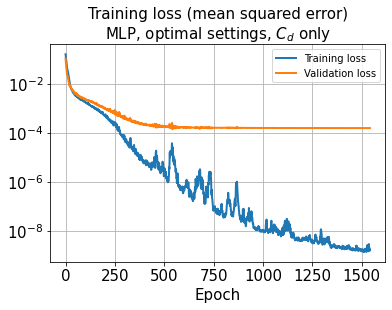

In [44]:
hist = history.history
plt.plot(hist['loss'], lw=2, label='Training loss')
plt.plot(hist['val_loss'], lw=2, label='Validation loss')
plt.title('Training loss (mean squared error)\nMLP, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "TrainingLoss_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

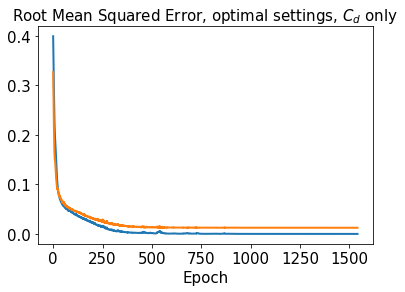

In [45]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title('Root Mean Squared Error, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

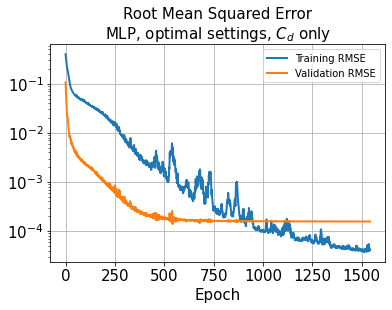

In [46]:
plt.plot(hist['rmse'], lw=2, label='Training RMSE')
plt.plot(hist['val_loss'], lw=2, label='Validation RMSE')
plt.title('Root Mean Squared Error\nMLP, optimal settings, $C_d$ only', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.grid()
plt.legend(loc='upper right')
saveName = "RMSE_test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [47]:
train_results = model.evaluate(x_train, y_train)

4/4 [==============================] - 0s 3ms/step - loss: 1.7320e-05 - rmse: 0.0042


In [48]:
test_results = model.evaluate(x_test, y_test)

1/1 [==============================] - 0s 18ms/step - loss: 3.2058e-04 - rmse: 0.0179


In [49]:
decoded_train_ = model.predict(x_train)
decoded_val_ = model.predict(x_val)
decoded_test_ = model.predict(x_test)

1/1 [==============================] - 0s 14ms/step


In [122]:
index_train = np.unique(np.where(np.isin(cd, y_train)))
index_val = np.unique(np.where(np.isin(cd, y_val)))
index_test = np.unique(np.where(np.isin(cd, y_test)))

In [50]:
y_train = y_train*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_val = y_val*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
y_test = y_test*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [51]:
decoded_train = decoded_train_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_val = decoded_val_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)
decoded_test = decoded_test_*(np.max(cd_orig)-np.min(cd_orig))+np.min(cd_orig)

In [52]:
model_directory = "D:\\TrainedModels\\20221130"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
os.chdir(model_directory)
model_name = "20221130steadyValidation_MLP_val_"+str(val_rate)+"_test"+str(test_rate)+ "_" + str(n_units) +"units_optimalSettings_Cdonly.h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [53]:
error_train_abs = np.abs(decoded_train - y_train)

In [54]:
error_val_abs = np.abs(decoded_val - y_val)

In [55]:
error_test_abs = np.abs(decoded_test - y_test)

In [56]:
os.chdir(storage_dir)

In [57]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.00835956666488748


In [58]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.022487445256487486


In [59]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.041702263263442674


In [60]:
l2_error_train_list = []
for i in range(0, len(x_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum((y_train[i]+1e-07)**2))
    l2_error_train_list.append(l2_error_train_data)

In [61]:
l2_error_val_list = []
for i in range(0, len(x_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum((y_val[i]+1e-07)**2))
    l2_error_val_list.append(l2_error_val_data)

In [62]:
l2_error_test_list = []
for i in range(0, len(x_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum((y_test[i]+1e-07)**2))
    l2_error_test_list.append(l2_error_test_data)

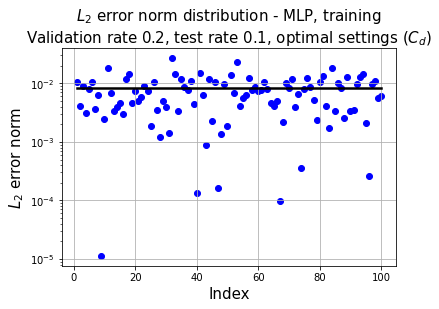

In [63]:
plt.plot(np.linspace(1,x_train.shape[0],x_train.shape[0]),
         l2_error_train*np.ones(x_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_train.shape[0], x_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, training\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "trainingErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

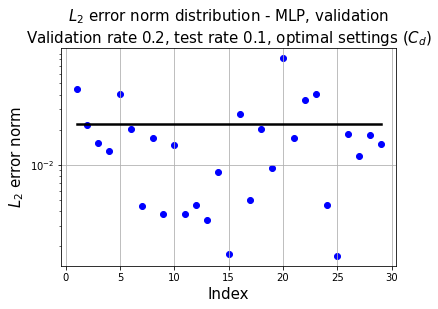

In [64]:
plt.plot(np.linspace(1,x_val.shape[0],x_val.shape[0]),
         l2_error_val*np.ones(x_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_val.shape[0], x_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, validation\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "validationErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

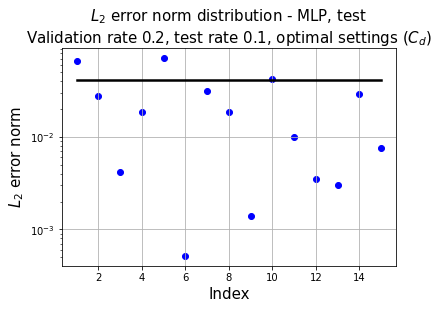

In [65]:
plt.plot(np.linspace(1,x_test.shape[0],x_test.shape[0]),
         l2_error_test*np.ones(x_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, x_test.shape[0], x_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title('$L_2$ error norm distribution - MLP, test\nValidation rate {0}, test rate {1}, optimal settings ($C_d$)'.format(
    val_rate, test_rate), fontsize=15
         )
plt.grid()
saveName = "testErrorDistribution.jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [66]:
predicted = model.predict(x)

5/5 [==============================] - 0s 2ms/step


In [97]:
index_train = np.unique(np.where(np.isin(cd_orig, y_train)))
index_val = np.unique(np.where(np.isin(cd_orig, y_val)))
index_test = np.unique(np.where(np.isin(cd_orig, y_test)))

In [101]:
len(index_train)+len(index_val)+len(index_test)

137

In [68]:
iTrain=[]
iVal=[]
iTest=[]
for i, index in enumerate(index_train):
    iTrain.append(y[index])
for i, index in enumerate(index_val):
    iVal.append(y[index])
for j, index in enumerate(index_test):
    iTest.append(y[index])

In [69]:
iTrain = np.array(iTrain)
iVal = np.array(iVal)
iTest = np.array(iTest)

In [89]:
def CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest):
    
    title_0_Cd = 'Gurney flap not attached (NACA0018)\n$C_D$ prediction, L2 error=%.4f' % l2_error_Cd
    #title_0_Cl = 'Gurney flap not attached (NACA0018)\n$C_L$ prediction, L2 error=%.4f' % l2_error_Cl
    
    title_n_Cd = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_D$ prediction, L2 error=%.4f'%(l2_error_Cd)
    #title_n_Cl = 'Gurney flap attached h=%.2f, '%(h[i]) + r'$\beta$=%d'%(beta[i])+'\n$C_L$ prediction, L2 error=%.4f'%(l2_error_Cl)
    
    if i==0:
#         title_Cd, title_Cl = title_0_Cd, title_0_Cl
#         savename1,savename2 = "CdComparison_NACA0018.jpg", "ClComparison_NACA0018.jpg"
        title_Cd = title_0_Cd
        savename1 = "CdComparison_NACA0018.jpg"
    else:
#         title_Cd, title_Cl = title_n_Cd, title_n_Cl
        title_Cd = title_n_Cd
        savename1 = "CdComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
#         savename2 = "ClComparison_h"+str(h[i])+"_beta"+str(beta[i])+".jpg"
    
    # CD graph plot
    plt.plot(alpha, CD, 'k-', label='Ground truth')
    plt.plot(alpha, cd, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain, color='b', label='Training set')
    plt.scatter(aVal, iVal, color='g', label='Validation set')
    plt.scatter(aTest, iTest, color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_D$')
    plt.title(title_Cd, fontsize=15)        
    plt.legend(loc='upper left')
    plt.ylim([0, 0.12])
    plt.grid()
    plt.savefig(savename1, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

    '''# CL graph plot
    plt.plot(alpha, CL, 'k-', label='Ground truth')
    plt.plot(alpha, cl, 'k--', label='Predicted value')
    plt.scatter(aTrain, iTrain[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='b', label='Training set')
    plt.scatter(aTest, iTest[:,1]*(np.max(cl_orig)-np.min(cl_orig)) + np.min(cl_orig), color='r', label='Test set')
    plt.xlabel('AoA (degree)')
    plt.ylabel('$C_L$')
    plt.title(title_Cl, fontsize=15)
    plt.legend(loc='upper left')
    plt.ylim([0, 2])
    plt.grid()
    plt.savefig(savename2, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()'''

1/1 [==============================] - 0s 15ms/step
NACA0018 airfoil without Gurney flap
L2 error of Cd: 0.0166


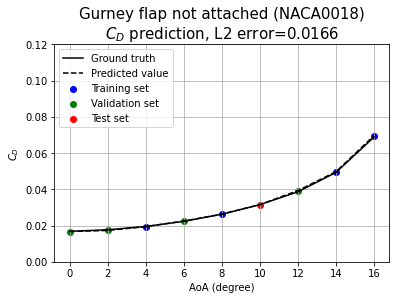

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0144


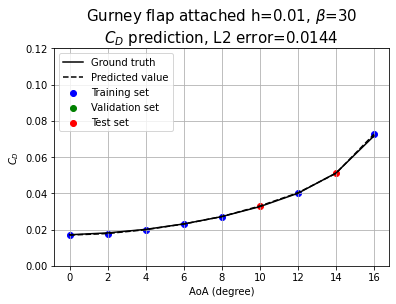

1/1 [==============================] - 0s 17ms/step
L2 error of Cd: 0.0175


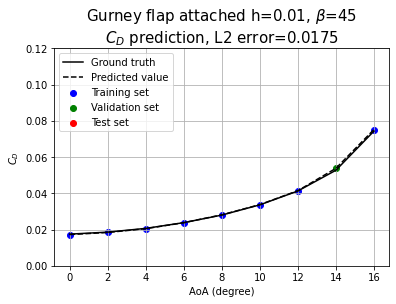

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0181


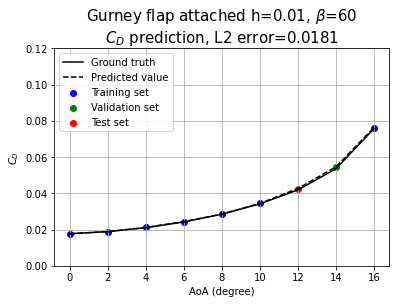

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0213


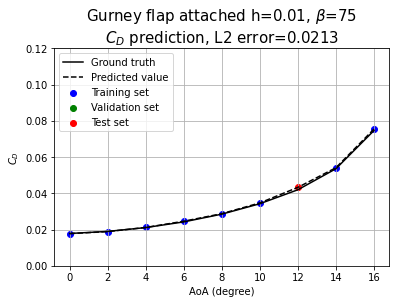

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0657


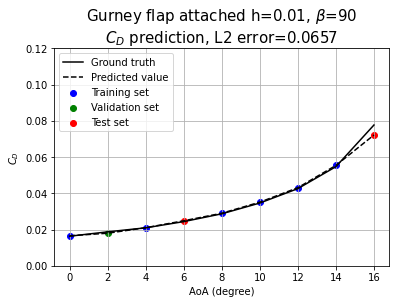

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0109


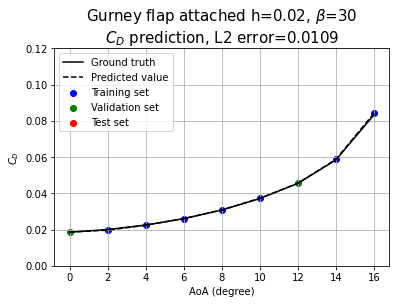

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0120


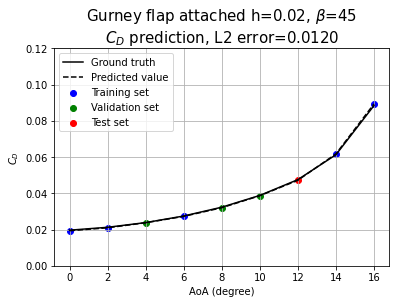

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0115


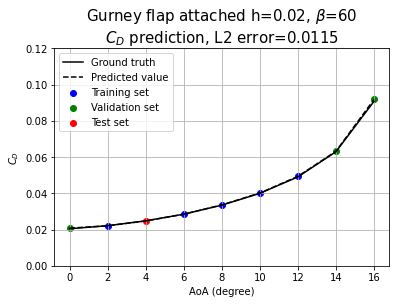

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0146


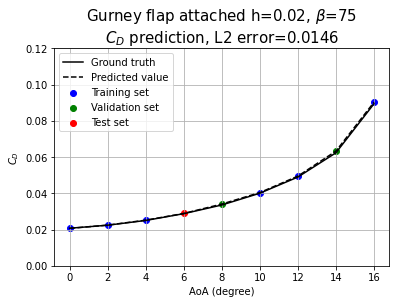

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0426


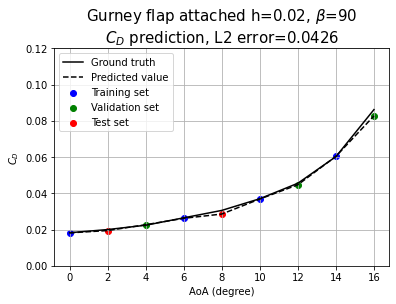

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0076


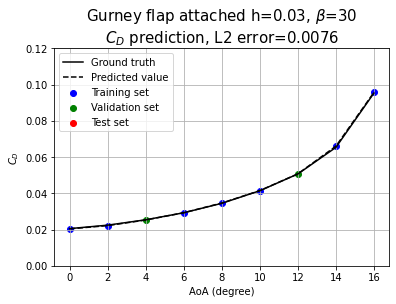

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0141


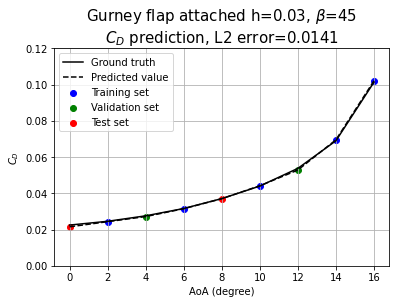

1/1 [==============================] - 0s 14ms/step
L2 error of Cd: 0.0098


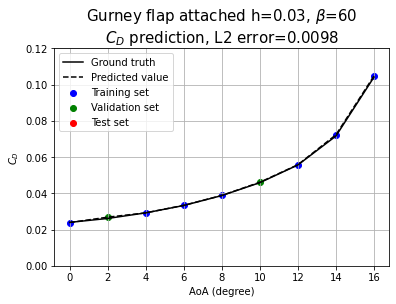

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0158


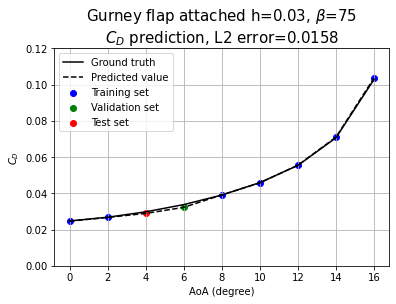

1/1 [==============================] - 0s 15ms/step
L2 error of Cd: 0.0321


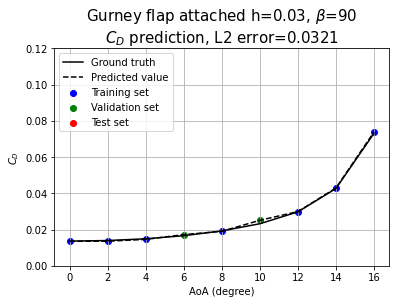

In [123]:
h = [0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.02, 0.02, 0.02, 0.02, 0.02, 0.03, 0.03, 0.03, 0.03, 0.03]
beta = [0, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90, 30, 45, 60, 75, 90]
for i in range(0, 16):
    # Index from each dataset
    iTrain = []
    iVal = []
    iTest = []
    
    # Index from input data (alpha, in this case)
    alpha_train = []
    alpha_val = []
    alpha_test = []
    
    predictedValue = model.predict(x[n_alpha*i:n_alpha*(i+1),:])
    y_corres = y[n_alpha*i:n_alpha*(i+1),:]
    
    l2_error_Cd = np.sqrt(np.sum((predictedValue - y_corres)**2) / np.sum(y_corres**2))
    
    if i==0:
        print('NACA0018 airfoil without Gurney flap\nL2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    else:
        print('L2 error of Cd: {0:0.4f}'.format(l2_error_Cd))
    
    cd = predicted[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    CD = y[n_alpha*i:n_alpha*(i+1)]*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        iTrain.append(predicted[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        iVal.append(predicted[index])    
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & (index_test>=i*n_alpha))]):
        iTest.append(predicted[index])
        
    iTrain = np.array(iTrain)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iTest = np.array(iTest)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    iVal = np.array(iVal)*(np.max(cd_orig)-np.min(cd_orig)) + np.min(cd_orig)
    
    for ii, index in enumerate(index_train[np.where((index_train<(i+1)*n_alpha) & ((index_train>=i*n_alpha)))]):
        alpha_train.append(aa[index])
    for kk, index in enumerate(index_val[np.where((index_val<(i+1)*n_alpha) & ((index_val>=i*n_alpha)))]):
        alpha_val.append(aa[index])
    for jj, index in enumerate(index_test[np.where((index_test<(i+1)*n_alpha) & ((index_test>=i*n_alpha)))]):
        alpha_test.append(aa[index])
        
    aTrain = np.array(alpha_train)*np.max(alpha)
    aVal = np.array(alpha_val)*np.max(alpha)
    aTest = np.array(alpha_test)*np.max(alpha)
    
    CD_trainTestSplit_Plot(i, CD, cd, aTrain, aTest, iTrain, iTest)